In [ ]:
import torch
import torchvision
import torch.nn as nn
from torchvision.datasets.utils import download_url
import torch.nn.functional as F
import os
import tarfile
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline


In [ ]:

dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

Using downloaded and verified file: ./cifar10.tgz


In [ ]:
# Extract from archive
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

In [ ]:
directory = '/content/data/cifar10'
print(os.listdir(directory))


['train', 'test']


In [ ]:
classes = os.listdir(directory+'/train')
print(classes)
output_size=len(classes)
print(output_size)

['deer', 'horse', 'ship', 'frog', 'dog', 'cat', 'automobile', 'airplane', 'truck', 'bird']
10


In [ ]:
deer = os.listdir(directory+'/train'+'/deer')
print(len(deer))
print(deer[:5])

5000
['4629.png', '1490.png', '2142.png', '2363.png', '2527.png']


In [ ]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [ ]:
train_dt = ImageFolder(directory+'/train', transform=ToTensor())
test_dt = ImageFolder(directory+'/test', transform=ToTensor())

In [ ]:
image,labels = train_dt[0]
print(image.shape,'<<image.shape &','label==',labels)


torch.Size([3, 32, 32]) <<image.shape & label== 0


In [ ]:
classes = train_dt.classes

In [ ]:
def show_image(image,label):
  print(classes[label])
  plt.axis('off')
  plt.imshow(image.permute(1,2,0))

airplane


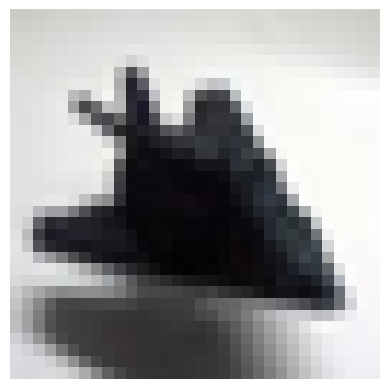

In [ ]:
show_image(*train_dt[0])

bird


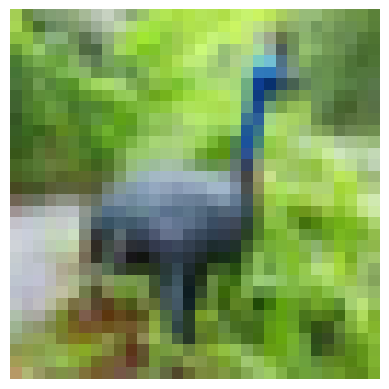

In [ ]:
show_image(*train_dt[10000])

In [ ]:
print(len(test_dt))
len(train_dt)

10000


50000

In [ ]:
random_seed = 42
torch.manual_seed(random_seed);

In [ ]:
val_ds= 5000
train_ds = len(train_dt)-val_ds
val_dt,train_dt = random_split(train_dt,[val_ds, train_ds])
len(val_dt),len(train_dt)

(5000, 45000)

In [ ]:
from torch.utils.data.dataloader import DataLoader
batch_size = 128
train_dl = DataLoader(train_dt,batch_size,shuffle=True,num_workers=2,pin_memory=True)
val_dl = DataLoader(val_dt,batch_size*2,shuffle=False,num_workers=2,pin_memory=True)
test_dl = DataLoader(test_dt,batch_size*2,shuffle=False,num_workers=2,pin_memory=True)

torch.Size([128, 3, 32, 32]) ==image.shape


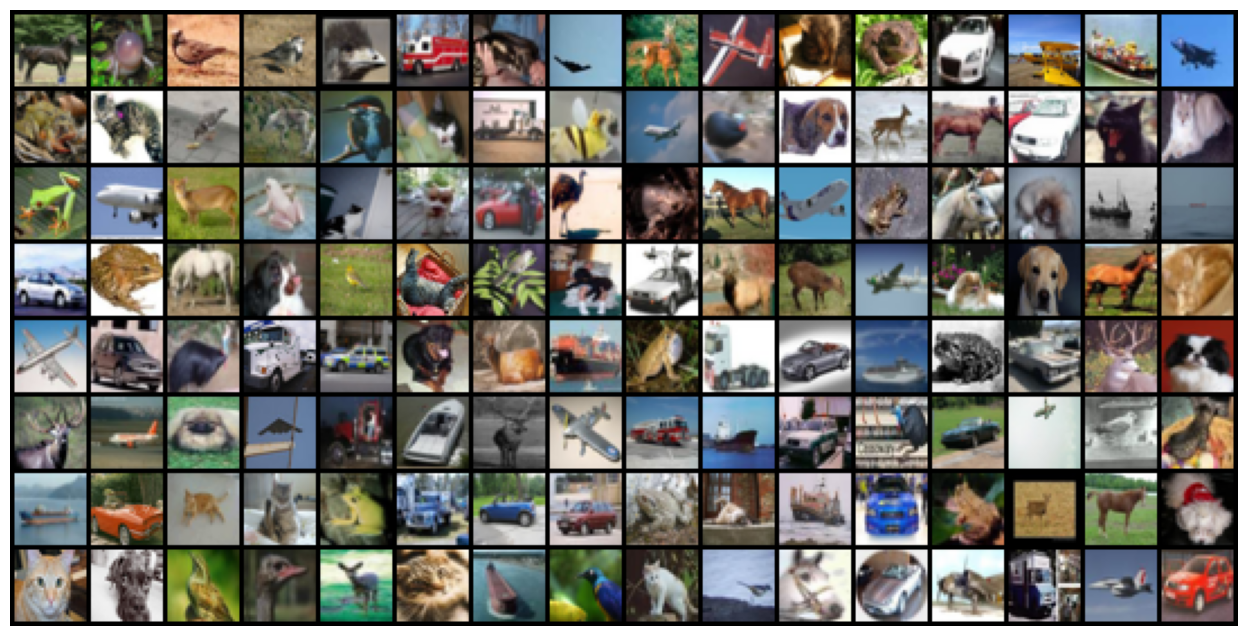

In [ ]:
from torchvision.utils import make_grid

for images, labels in train_dl:
  print(images.shape, '==image.shape' )
  plt.figure(figsize=(16,8))
  plt.axis('off')
  plt.imshow(make_grid(images, nrow=16).permute(1,2,0))
  break

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

In [ ]:
class ImageClassifier(nn.Module):
  def training_step(self,batch):
    images,labels = batch
    out = self(images)
    loss = F.cross_entropy(out,labels)
    return loss
  def validation_step(self,batch):
    images,labels = batch
    out = self(images)
    loss = F.cross_entropy(out,labels)
    acc = accuracy(labels,out)
    return {'val_loss':loss.detach(), 'val_acc':acc}
  def validation_epoch_end(self,outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()
    batch_acc = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_acc).mean()
    return {'val_acc':epoch_acc.item(), 'val_loss':epoch_loss.item()}
  def epoch_end(self, epoch, result):
      print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
          epoch, result['train_loss'], result['val_loss'], result['val_acc']))





In [ ]:
def accuracy(labels,outputs):
  probs,preds = torch.max(outputs,dim=1)
  return torch.tensor(torch.sum(preds==labels).item()/len(preds))


In [ ]:
class CNN_ImageClassifier(ImageClassifier):
  def __init__(self):
    super().__init__()
    self.network = nn.Sequential(
        nn.Conv2d(3,32,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2),

        nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(128,128,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2),

        nn.Conv2d(128,256,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2),

        nn.Flatten(),
        nn.Linear(256*4*4,1024),
        nn.ReLU(),
        nn.Linear(1024,512),
        nn.ReLU(),
        nn.Linear(512,10)

    )
  def forward(self,xb):
    out = self.network(xb)
    return out


In [ ]:
model = CNN_ImageClassifier()
to_device(model, device);
model

CNN_ImageClassifier(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_

In [ ]:
for batch in train_dl:
  images,labels  = batch
  output = model(images)
  print('images.shape=',images.shape)
  print(output.shape ,'==output.shape')
  break

images.shape= torch.Size([128, 3, 32, 32])
torch.Size([128, 10]) ==output.shape


In [ ]:
@torch.no_grad()
def evaluate(model,dataloader):
  model.eval()
  outputs = [model.validation_step(batch) for batch in dataloader]
  return model.validation_epoch_end(outputs)

def fit(epochs,lr,model,train_dl,val_dl,opt_func=torch.optim.Adam):
  optimizer = opt_func(model.parameters(),lr)
  history=[]

  for epoch in range(epochs):
    model.train()
    train_losses = []
    for batch in train_dl:
      loss = model.training_step(batch)
      train_losses.append(loss)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    results = evaluate(model,val_dl)
    results['train_loss'] = torch.stack(train_losses).mean().item()
    model.epoch_end(epoch,results)
    history.append(results)

  return history


In [ ]:
lr = 0.0001
epochs=20

In [ ]:
evaluate(model, val_dl)

{'val_acc': 0.10399816185235977, 'val_loss': 2.302802562713623}

In [ ]:
history = fit(epochs,lr,model,train_dl,val_dl)

Epoch [0], train_loss: 1.8879, val_loss: 1.6222, val_acc: 0.3944
Epoch [1], train_loss: 1.5464, val_loss: 1.4983, val_acc: 0.4506
Epoch [2], train_loss: 1.4190, val_loss: 1.3894, val_acc: 0.4940
Epoch [3], train_loss: 1.3098, val_loss: 1.2752, val_acc: 0.5458
Epoch [4], train_loss: 1.2200, val_loss: 1.1967, val_acc: 0.5663
Epoch [5], train_loss: 1.1322, val_loss: 1.1593, val_acc: 0.5782
Epoch [6], train_loss: 1.0710, val_loss: 1.1007, val_acc: 0.6050
Epoch [7], train_loss: 1.0118, val_loss: 1.0536, val_acc: 0.6153
Epoch [8], train_loss: 0.9463, val_loss: 0.9810, val_acc: 0.6481
Epoch [9], train_loss: 0.8944, val_loss: 0.9367, val_acc: 0.6692
Epoch [10], train_loss: 0.8531, val_loss: 0.9156, val_acc: 0.6754
Epoch [11], train_loss: 0.8102, val_loss: 0.8535, val_acc: 0.6980
Epoch [12], train_loss: 0.7621, val_loss: 0.8509, val_acc: 0.7038
Epoch [13], train_loss: 0.7328, val_loss: 0.8009, val_acc: 0.7114
Epoch [14], train_loss: 0.6882, val_loss: 0.7825, val_acc: 0.7301
Epoch [15], train_lo

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

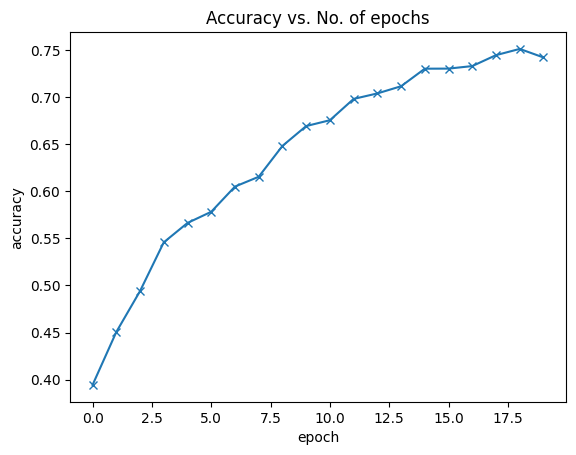

In [ ]:
plot_accuracies(history)

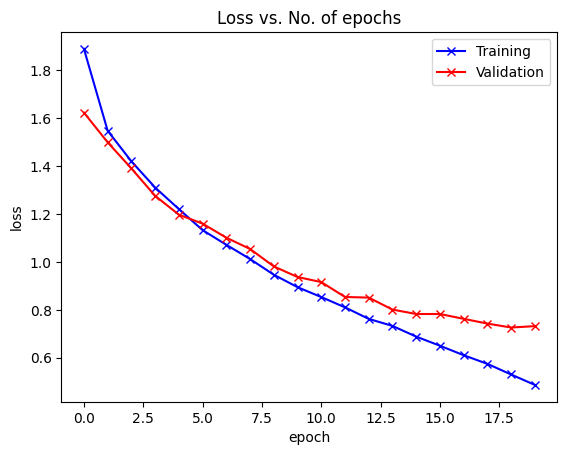

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
plot_losses(history)

In [ ]:
evaluate(model,test_dl)

{'val_acc': 0.7479492425918579, 'val_loss': 0.7478371262550354}

In [ ]:
CNN_ImageClassifier_weights = 'CNN_ImageClassifier.pth'
torch.save(model.state_dict(),CNN_ImageClassifier_weights)